
The dataset includes a diverse set of URLs, both benign and malicious, accompanied by an extensive list of calculated features. These features cover various aspects of URLs, providing a holistic view to aid in the identification of potential threats.
Key feature types:

1. Basic URL Components
2. Domain Information
3. Content Analysis
4. Path and Query Parameters
5. SSL Certificate Details
6. Host Reputation
7. Network Features
8. Machine Learning-Derived Features
9. Behavioural Features

Researchers and data scientists can leverage this dataset to develop and benchmark URL detection models, employing various machine learning and deep learning techniques.
The abundance of calculated features offers a rich resource for exploring novel approaches to enhance the accuracy and robustness of URL classification systems. Additionally, the dataset encourages collaboration and the sharing of insights within the cybersecurity community.

## Importing Necessary Libraries

In [32]:
import patoolib # Used to extract archive files
import os # Used for os operations
import pandas as pd # Used to create pandas dataframe
from pyspark.sql import SparkSession # Used for initiating the Spark Session
import numpy as np # Used for numerical operations on arrays
import matplotlib.pyplot as plt # Used for data visualisation
import seaborn as sns # Used for data visualisation
from sklearn.metrics import classification_report, confusion_matrix # Used to evaluate the model
from pyspark.ml.feature import VectorAssembler # Used to convert columns into vectors
from pyspark.ml import Pipeline # Used to create a Spark ML Pipeline
from pyspark.ml.classification import RandomForestClassifier as SparkRFClassifier # Used to create Random Forest Model
from pyspark.ml.classification import LogisticRegression as LR # Used to create a Logistic Regression Model
from pyspark.ml.classification import NaiveBayes # Used to create Naive Bayes Model
from pyspark.ml.evaluation import BinaryClassificationEvaluator # Used to evaluate the model
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator # Used to finetune the model

## Data Extraction and Reading the data 

In [2]:
patoolib.extract_archive("archive.zip") # Extracting the dataset file

In [3]:
os.listdir("archive") # Viewing the unzipped folder

['test_dataset.csv', 'train_dataset.csv']

In [4]:
# Initiating the Spark Session for spark operations
spark = SparkSession.builder.appName("Spark").config("spark_option", "value").getOrCreate()

In [5]:
#Reading the train dataset
df = spark.read.csv("archive/train_dataset.csv", inferSchema=True, header=True)
df.show()

+--------------------+-----+--------------------+-------------+--------------+--------------+-------------+----------+-------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------+---------------+--------------+--------------+----------------+-------------+----------------+--------------+-------------------+--------------------+--------------+---------------+-------------+----------------+---------------+-----------------------------------+-------------------------+-----------------------+--------+--------------------+----------------------+---------------+-------------------+----------------------------+----------------+----------------+-------------------+----------------------+-----------------+---------+----------------------+-----------+--------------------+--------------------+--------------------------+-------------------+-------+------+----------+-------

## Exploratory Data Analysis

In [6]:
# To count the total rows in the dataframe.
print('Number of rows: \t', df.count())
# Number of columns can be counted in this way
print('Number of columns: \t', len(df.columns))
# To view the names of the columns
print('\nName of columns: \n', df.columns)

Number of rows: 	 6728848
Number of columns: 	 60

Name of columns: 
 ['url', 'label', 'source', 'url_has_login', 'url_has_client', 'url_has_server', 'url_has_admin', 'url_has_ip', 'url_isshorted', 'url_len', 'url_entropy', 'url_hamming_1', 'url_hamming_00', 'url_hamming_10', 'url_hamming_01', 'url_hamming_11', 'url_2bentropy', 'url_3bentropy', 'url_count_dot', 'url_count_https', 'url_count_http', 'url_count_perc', 'url_count_hyphen', 'url_count_www', 'url_count_atrate', 'url_count_hash', 'url_count_semicolon', 'url_count_underscore', 'url_count_ques', 'url_count_equal', 'url_count_amp', 'url_count_letter', 'url_count_digit', 'url_count_sensitive_financial_words', 'url_count_sensitive_words', 'url_nunique_chars_ratio', 'path_len', 'path_count_no_of_dir', 'path_count_no_of_embed', 'path_count_zero', 'path_count_pertwent', 'path_has_any_sensitive_words', 'path_count_lower', 'path_count_upper', 'path_count_nonascii', 'path_has_singlechardir', 'path_has_upperdir', 'query_len', 'query_count

Due to limited resources, we can only work on 500,000 records on a single machine. Hence, cropping the dataset with only 500,000 records

In [7]:
df_class0 = df.filter(df["label"] == 0).limit(250000) # Creating a dataframe with 250k records that have label as 0
df_class1 = df.filter(df["label"] == 1).limit(250000) # Creating a dataframe with 250k records that have label as 1
df = df_class0.union(df_class1) # Merging the two dataframes to create one balanced dataframe
df.show()

+--------------------+-----+--------------------+-------------+--------------+--------------+-------------+----------+-------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------+---------------+--------------+--------------+----------------+-------------+----------------+--------------+-------------------+--------------------+--------------+---------------+-------------+----------------+---------------+-----------------------------------+-------------------------+-----------------------+--------+--------------------+----------------------+---------------+-------------------+----------------------------+----------------+----------------+-------------------+----------------------+-----------------+---------+----------------------+-----------+--------------------+--------------------+--------------------------+-------------------+-------+------+----------+-------

In [8]:
df.describe().show() # Describing the dataset

+-------+--------------------+----------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-----------------+------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-----------------+-------------------+-------------------+-----------------+----------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+-----------------+------------------+-----------------------------------+-------------------------+-----------------------+-----------------+--------------------+----------------------+-----------------+-------------------+----------------------------+-----------------+------------------+-------------------+----------------------+-------------------+------------------+-----------

In [9]:
# Viewing the null values in each column
print("Column Name \t\t\t Count of null values")
for col in df.columns:
    print(f"{col} \t\t\t\t\t {df.filter(df[col].isNull()).count()}")

Column Name 			 Count of null values
url 					 0
label 					 0
source 					 0
url_has_login 					 0
url_has_client 					 0
url_has_server 					 0
url_has_admin 					 0
url_has_ip 					 0
url_isshorted 					 0
url_len 					 0
url_entropy 					 0
url_hamming_1 					 0
url_hamming_00 					 0
url_hamming_10 					 0
url_hamming_01 					 0
url_hamming_11 					 0
url_2bentropy 					 0
url_3bentropy 					 0
url_count_dot 					 0
url_count_https 					 0
url_count_http 					 0
url_count_perc 					 0
url_count_hyphen 					 0
url_count_www 					 0
url_count_atrate 					 0
url_count_hash 					 0
url_count_semicolon 					 0
url_count_underscore 					 0
url_count_ques 					 0
url_count_equal 					 0
url_count_amp 					 0
url_count_letter 					 0
url_count_digit 					 0
url_count_sensitive_financial_words 					 0
url_count_sensitive_words 					 0
url_nunique_chars_ratio 					 0
path_len 					 0
path_count_no_of_dir 					 0
path_count_no_of_embed 					 0
path_count_zero 					 0
path_count_pertwent 				

In [10]:
# Extracting numerical and categorical columns for Exploratory data analysis
cat_columns = [] # Creating an array for categorical columns
num_columns = [] # Creating an array for numerical columns
for i in df.dtypes:
    if i[1] == "string":
        cat_columns.append(i[0])
    
    else:
        num_columns.append(i[0])


In [11]:
df.select(cat_columns).show()

+--------------------+--------------------+------+
|                 url|              source|   tld|
+--------------------+--------------------+------+
|    cpuggsukabumi.id|    majestic_million|    id|
|members.tripod.co...|data_clean_test_m...|   com|
|        topoz.com.pl|        dmoz_harvard|com.pl|
|           akopos.lt|        dmoz_harvard|    lt|
|         paha.org.uk|    majestic_million|org.uk|
| edwardsandlien.com/|data_clean_train_...|   com|
|vercontracheque.c...|          alexatop1m|com.br|
|centreforcomposer...|              domcop|   org|
|          creora.com|data_clean_train_...|   com|
|        .yar-doma.ru|        dmoz_harvard|    ru|
|              eg2.fr|    majestic_million|    fr|
|private-education.ru|        dmoz_harvard|    ru|
|          team3-l.jp|          alexatop1m|    jp|
|linturi.fi/100_ph...|data_clean_train_...|    fi|
|     reggaespace.com|              domcop|   com|
| garysdivemexico.com|        dmoz_harvard|   com|
|  danielkfreeman.com|    majes

In [12]:
df.select(num_columns).show()

+-----+-------------+--------------+--------------+-------------+----------+-------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------+---------------+--------------+--------------+----------------+-------------+----------------+--------------+-------------------+--------------------+--------------+---------------+-------------+----------------+---------------+-----------------------------------+-------------------------+-----------------------+--------+--------------------+----------------------+---------------+-------------------+----------------------------+----------------+----------------+-------------------+----------------------+-----------------+---------+----------------------+-----------+--------------------+--------------------+--------------------------+-------------------+-------+----------+--------------------+-------------+-------------------+


In [13]:
def barplot(df, col, lim=10, yname=None):
    
    '''
    This function makes a bar plot for the Spark dataframe df 
    for categorical column col only selecting top categories 
    as specified by lim. 
    '''
    
    # Grouping by the categories, counting on each categories 
    # and ordering them by the count
    classes = df.groupBy(col).count().orderBy('count', ascending=False)
    
    # Take first 'lim' number of rows and convert to pandas  
    pd_df = classes.limit(lim).toPandas()
    
    # Making plot 
    pd_df.plot(kind='bar', x=col, legend=False)
    plt.ylabel(yname)
    plt.show()

def pieplot(df, col, lim=10):
    
    '''
    This function makes a pie chart for the Spark dataframe df 
    for categorical column col only selecting top categories 
    as specified by lim. 
    '''
    
    # Grouping by the categories, counting on each categories 
    # and ordering them by the count
    classes = df.groupBy(col).count().orderBy('count', ascending=False)
    
    # Take first 'lim' number of rows and convert to pandas  
    pd_df = classes.limit(lim).toPandas()
    
    # Making plot 
    pd_df.plot(kind='pie', x=col, y='count', \
           labels=pd_df[col], legend=False)
    plt.show()

### Univariate Analysis

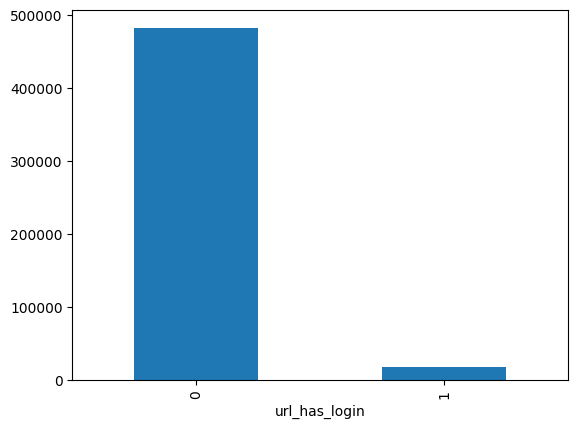

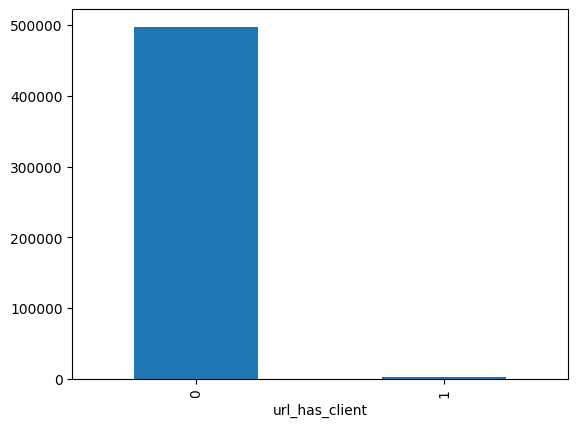

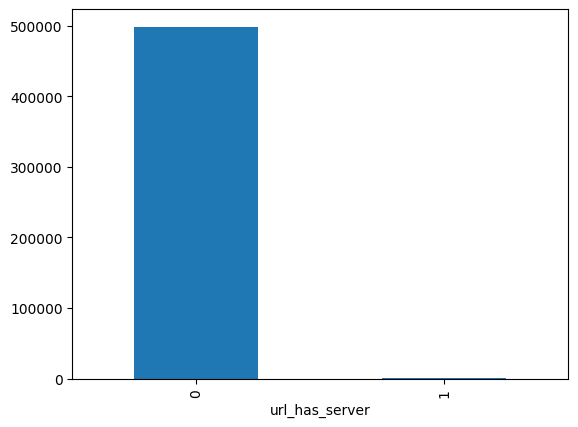

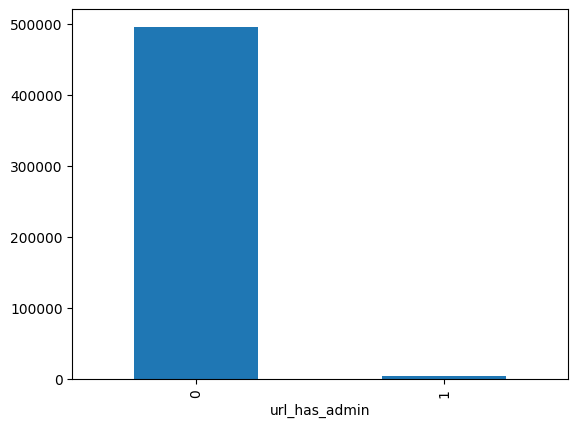

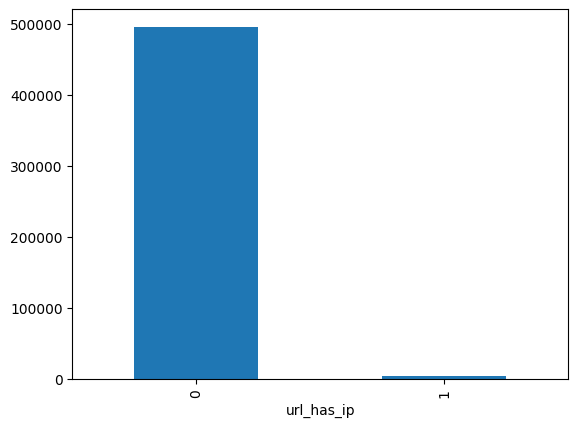

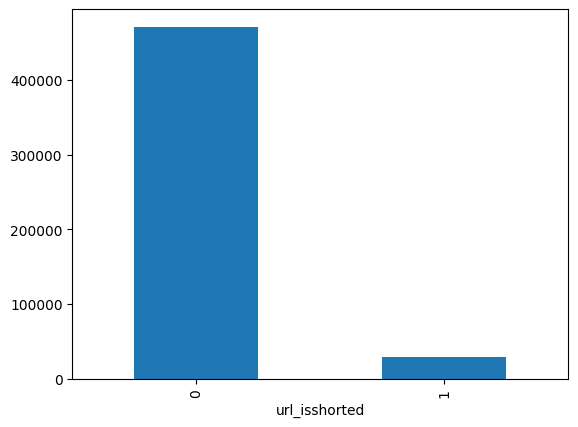

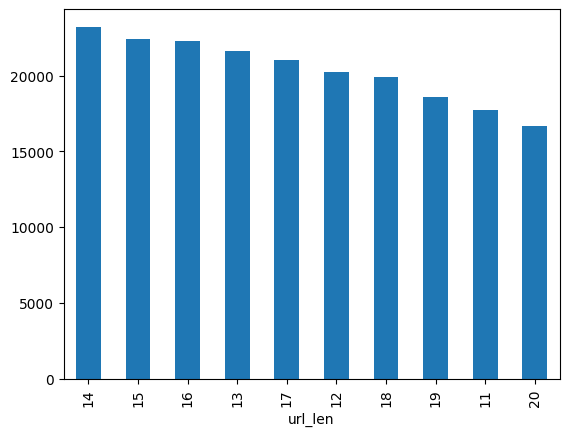

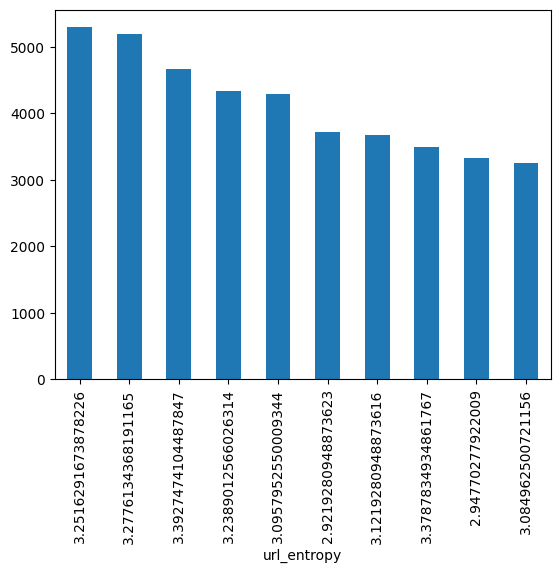

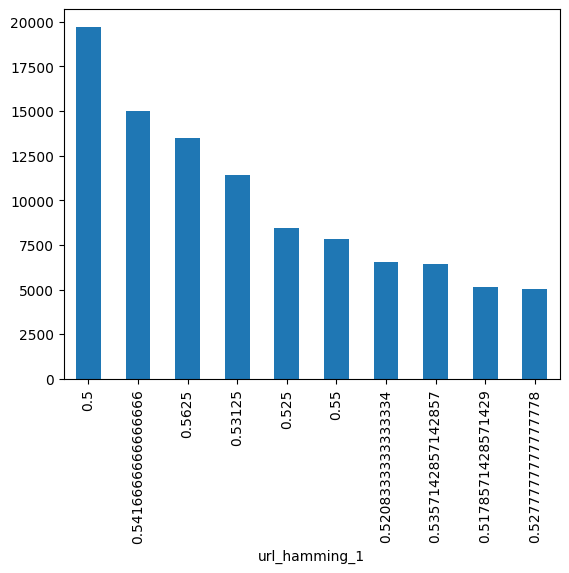

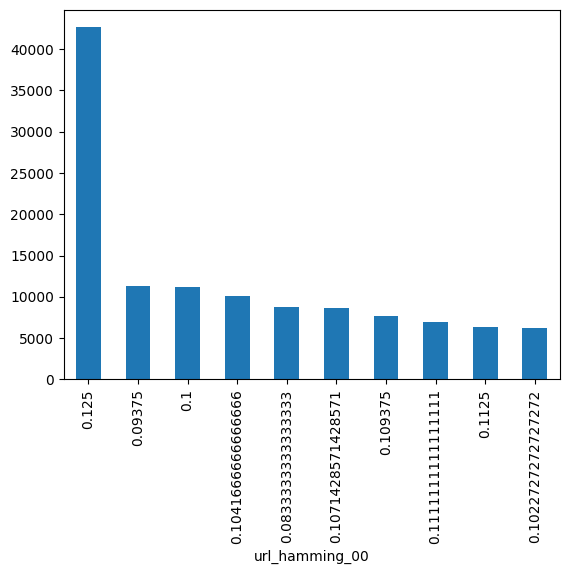

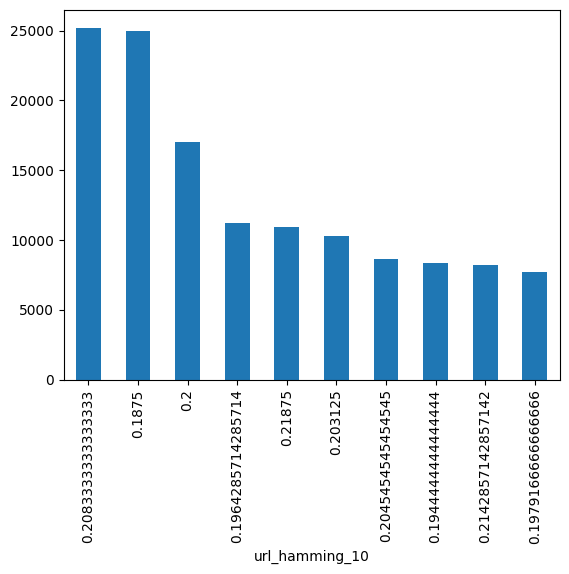

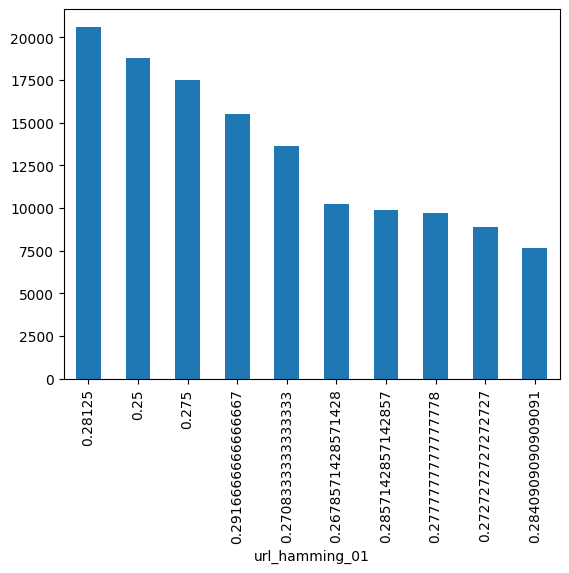

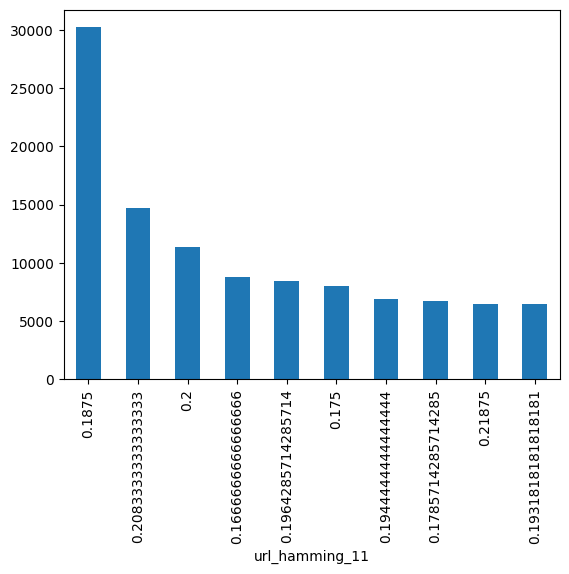

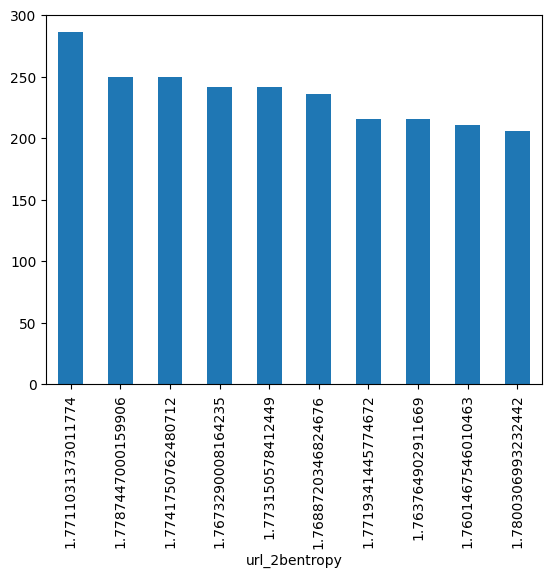

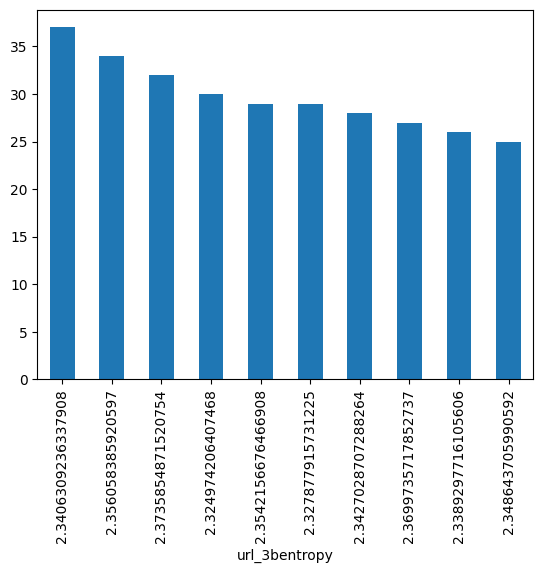

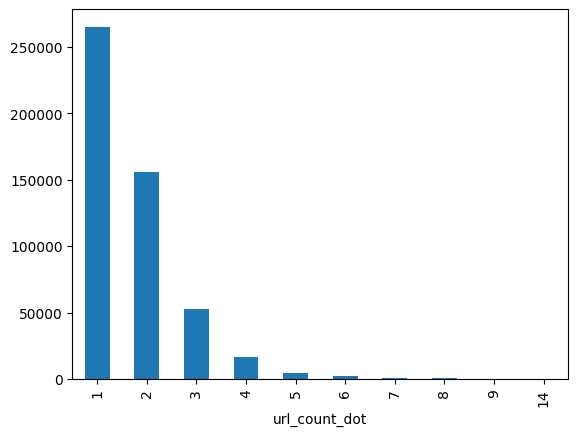

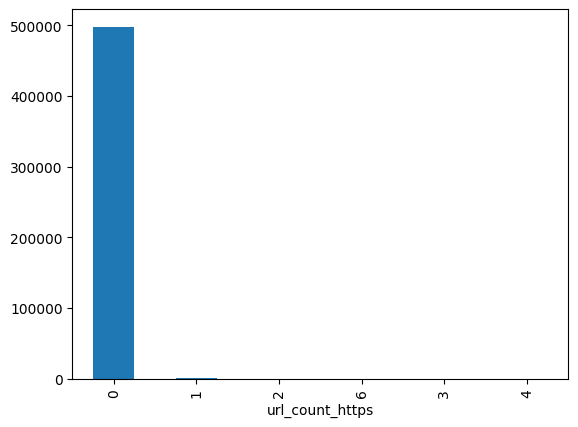

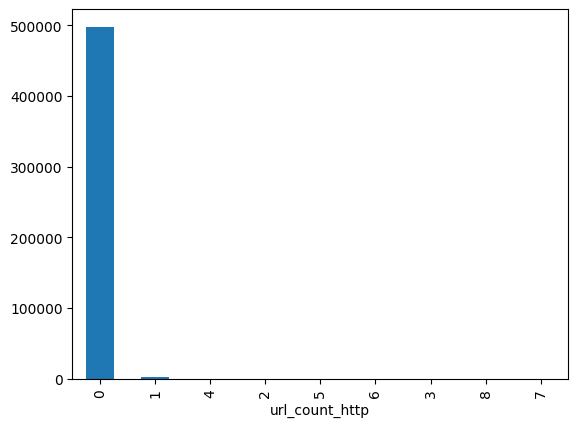

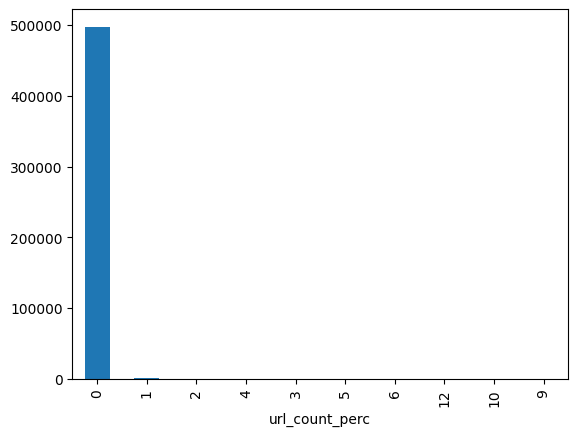

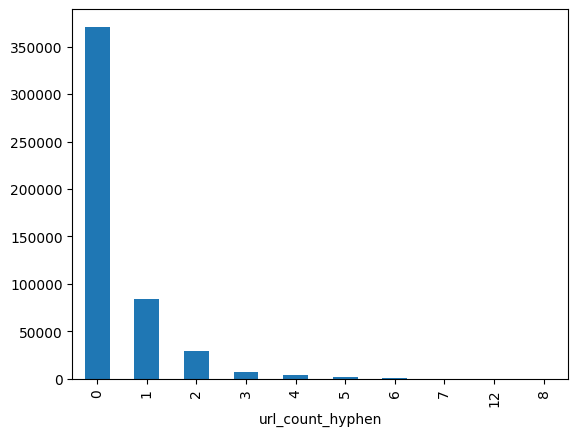

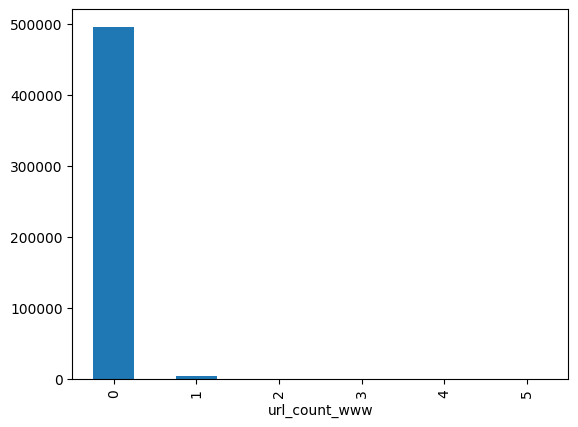

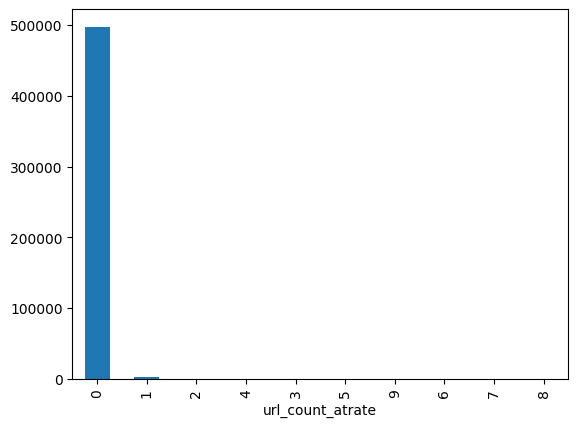

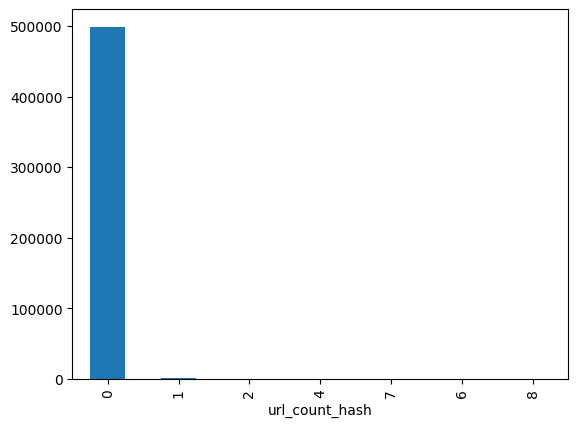

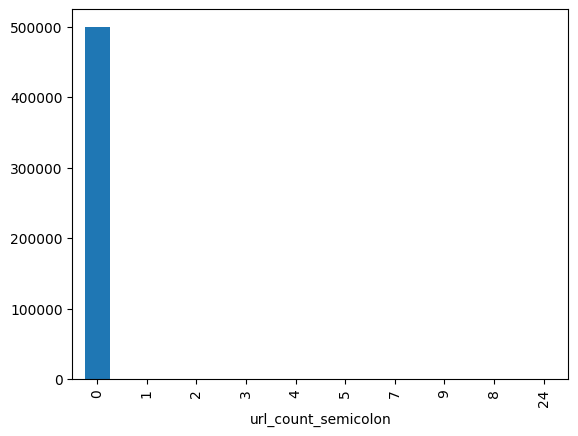

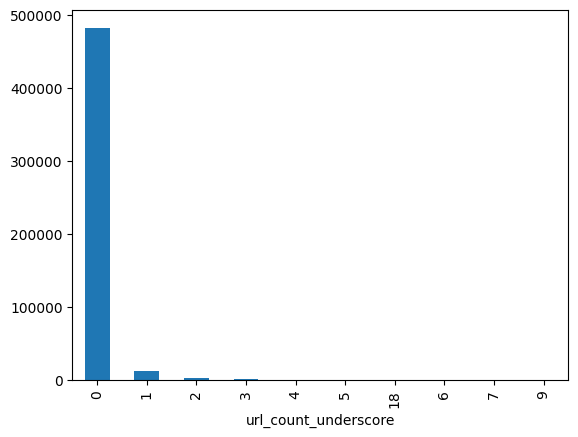

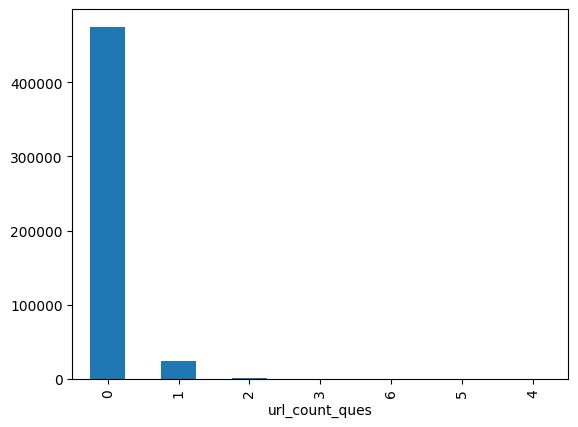

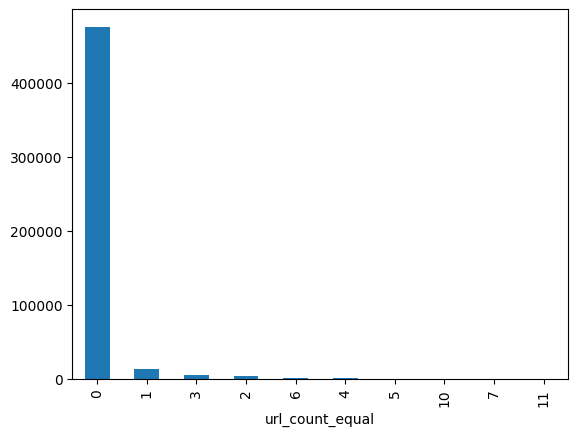

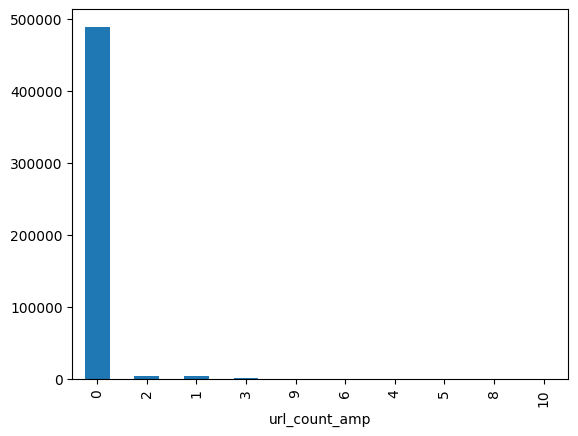

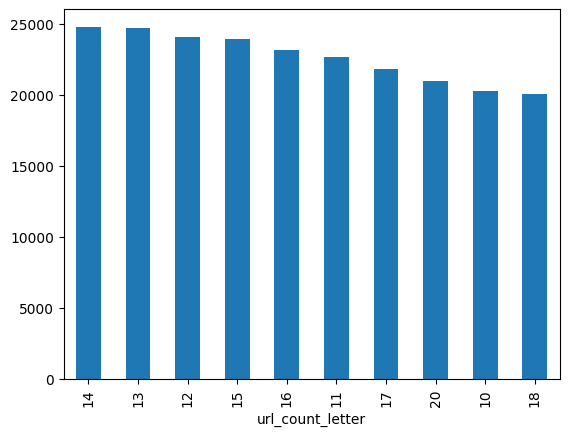

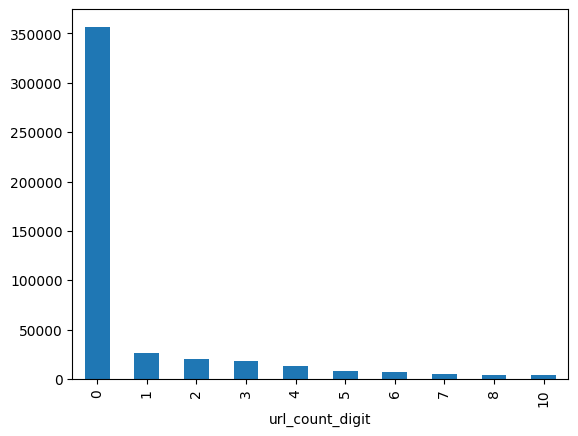

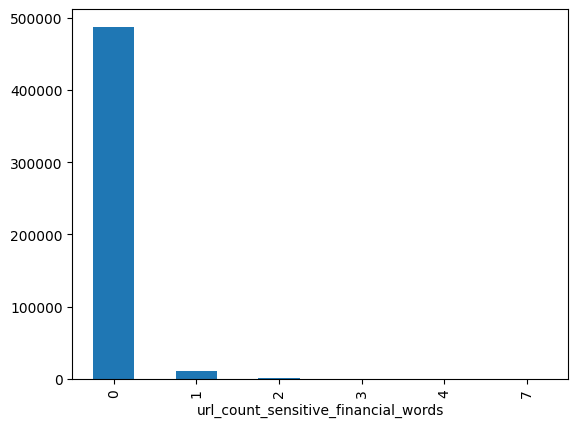

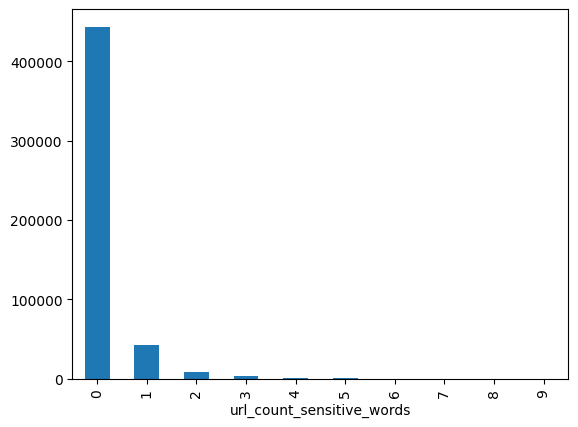

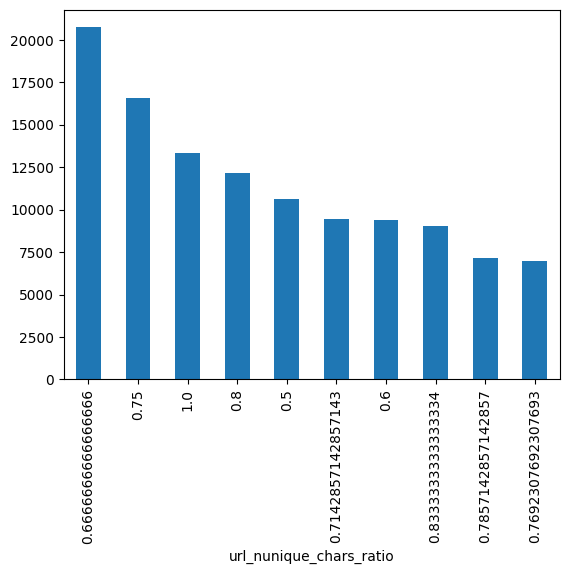

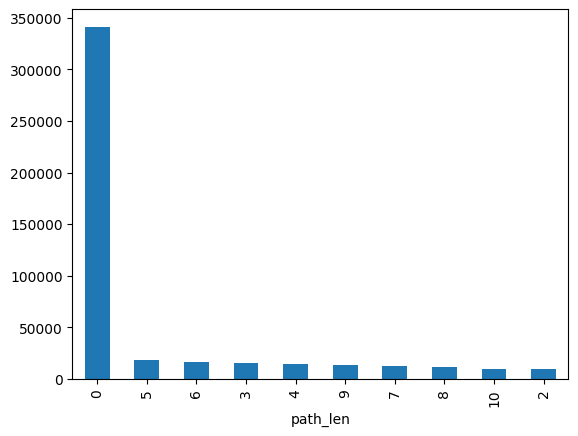

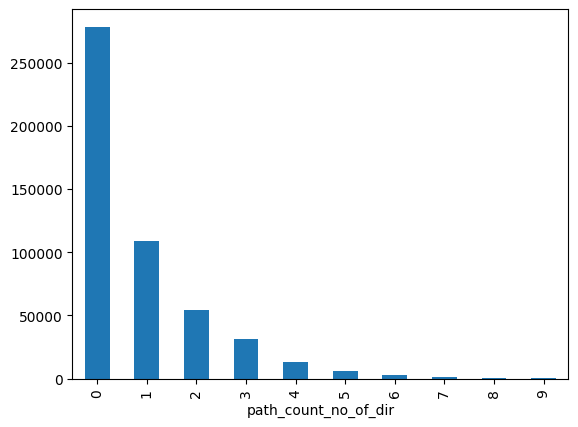

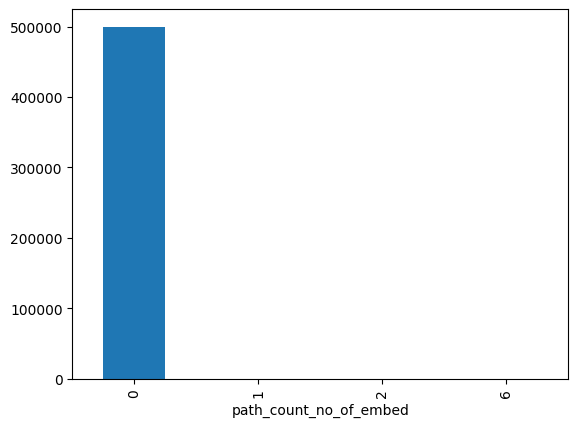

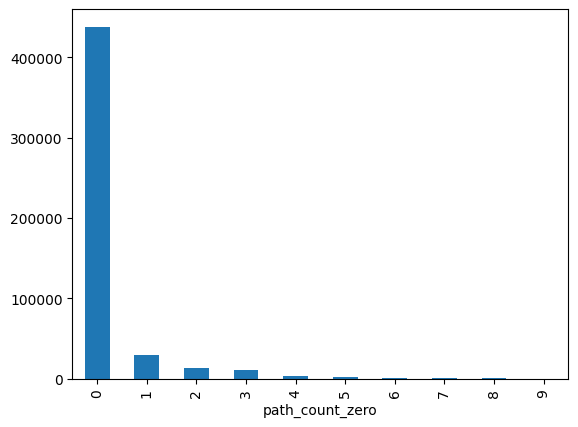

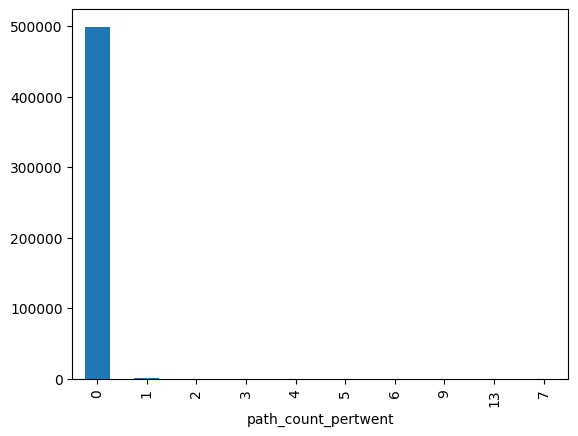

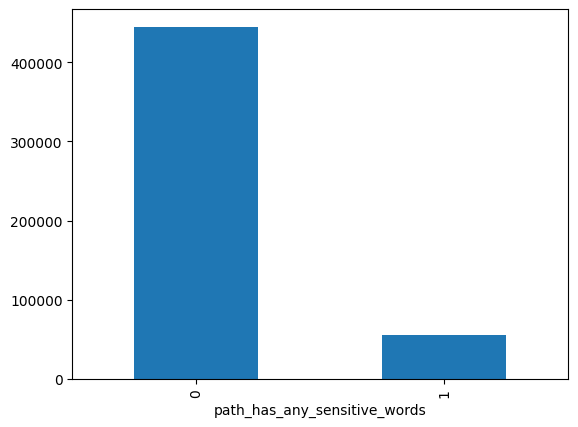

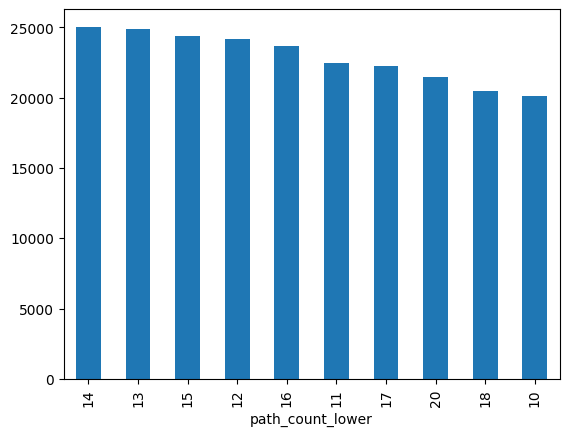

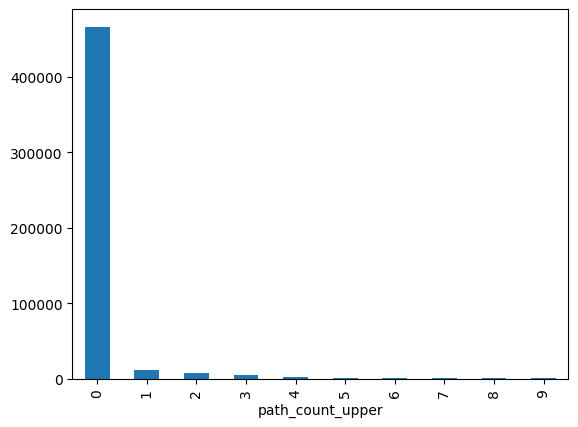

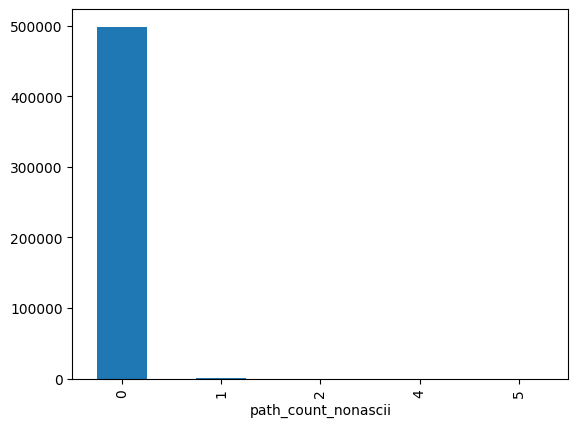

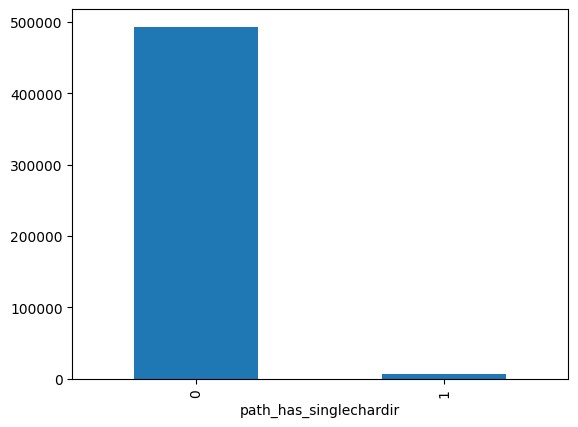

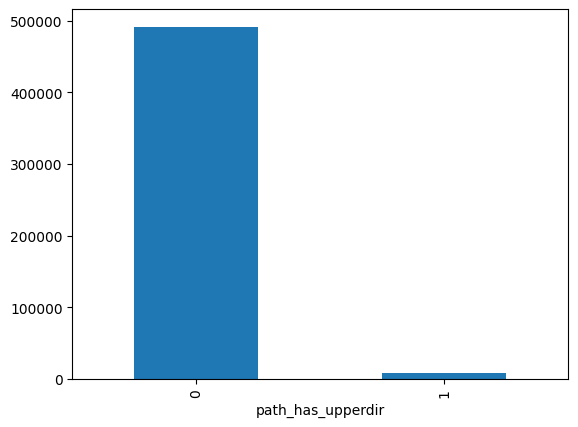

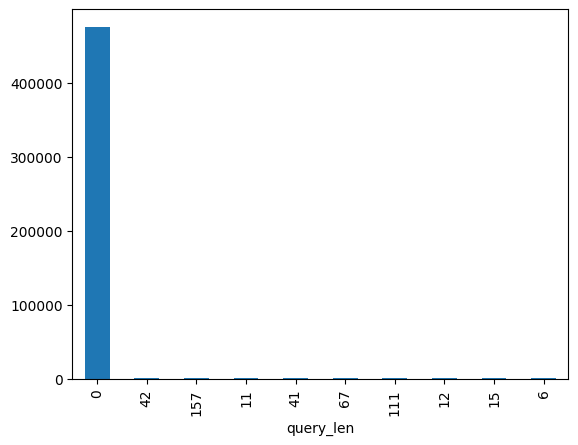

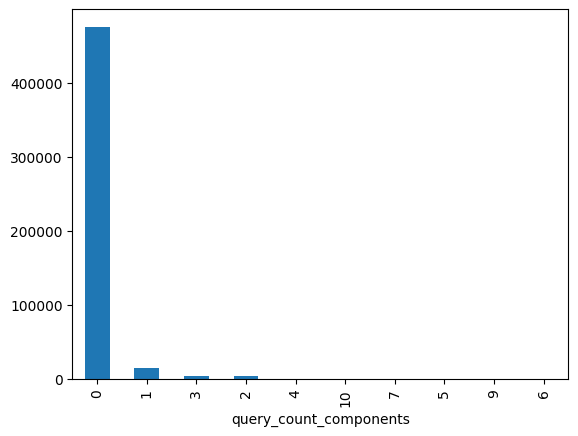

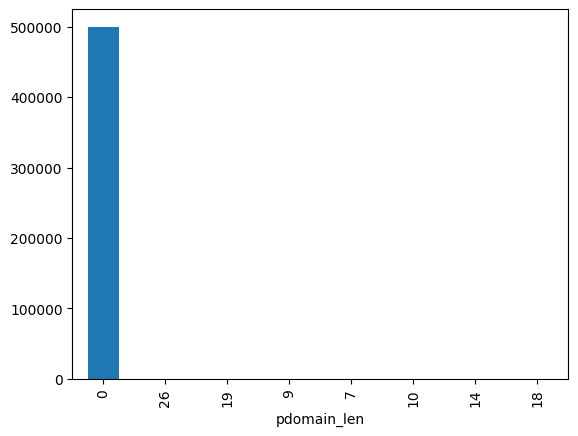

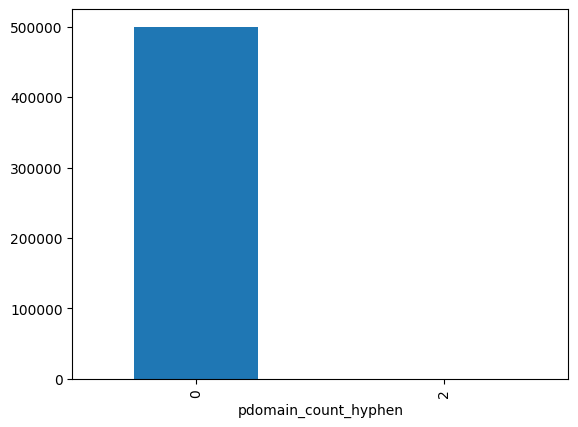

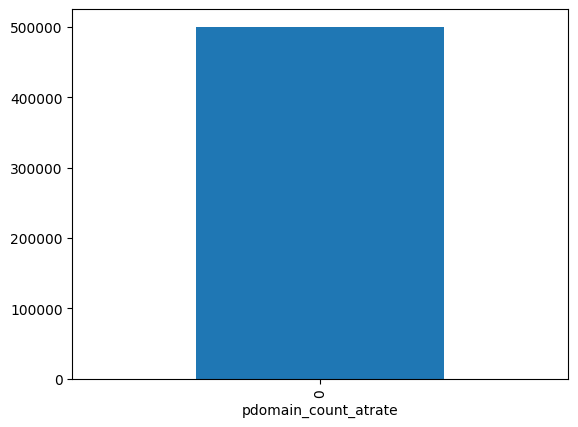

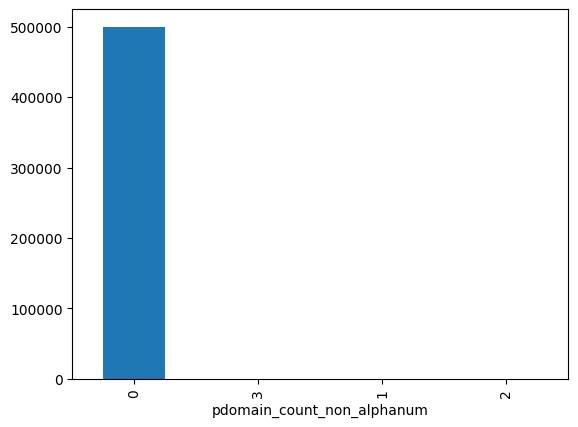

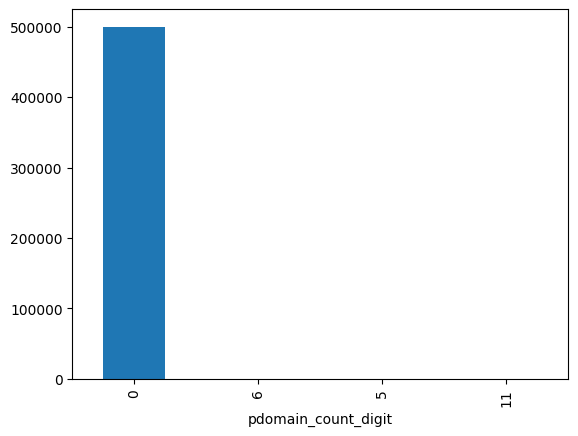

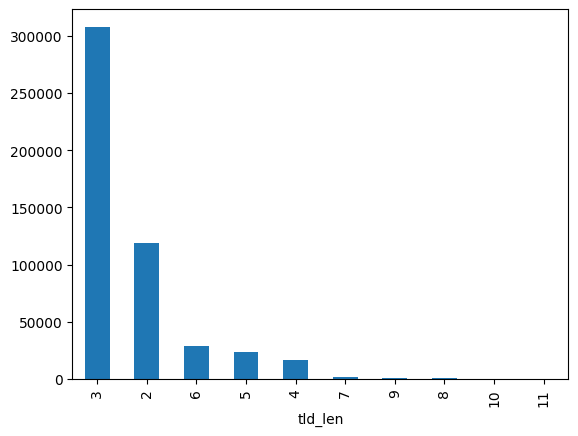

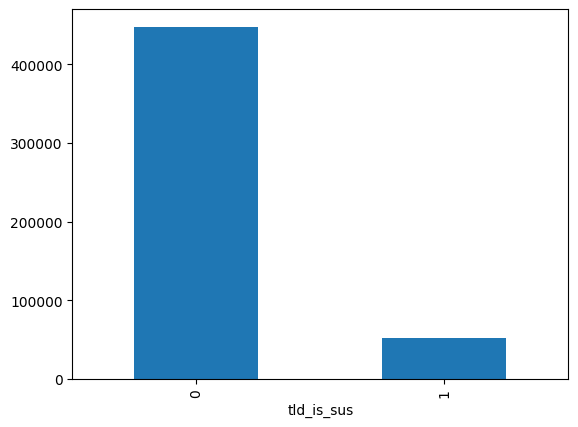

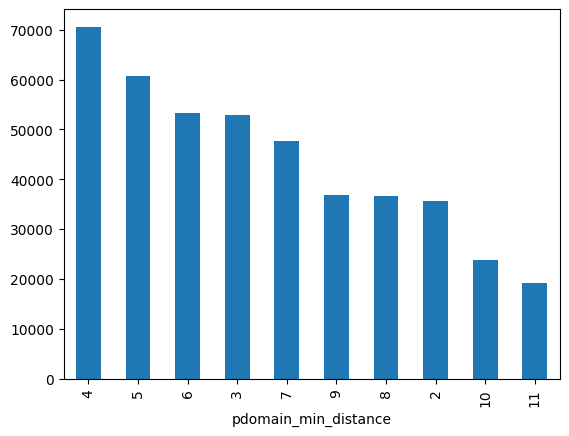

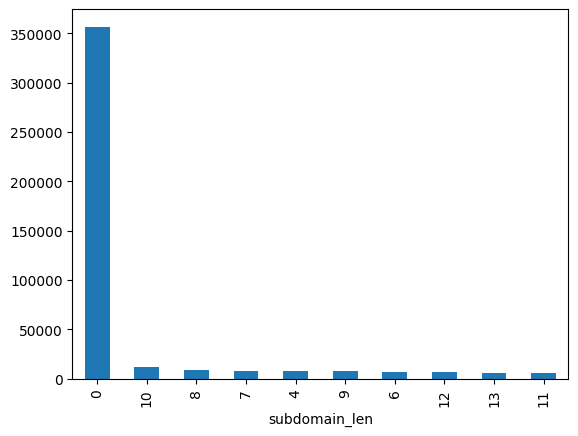

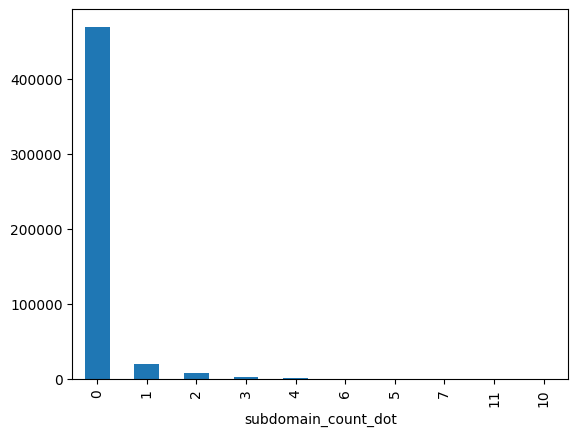

In [14]:
for i in range(1, len(num_columns)):
    barplot(df, num_columns[i])

Since most of the columns are highly skewed, we need to select the columns that are not extremely skewed for better model building. Columns that are highly skewed will not be significant for model prediction and increases model complexity. Considering the same, the columns that will be utilized for model building are as follows:-

1. url_len
2. url_entropy
3. url_hamming_1
4. url_hamming_00
5. url_hamming_01
6. url_hamming_10
7. url_hamming_11
8. url_2bentropy
9. url_3bentropy
10. url_count_dot
11. url_count_letter
12. url_nunique_chars_ratio
13. path_count_no_of_dir
14. path_count_lower
15. pdomain_min_distance

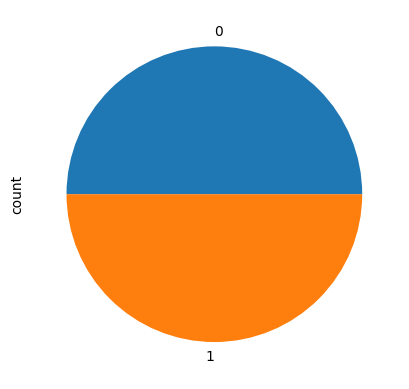

In [15]:
pieplot(df, 'label')

Above graph tells us that our data is balanced, having equal records for each category of the target. Here, value 0 represents URLs that are not malicious and 1 denotes the URLs that are dangerous.

### Multivariate Analysis

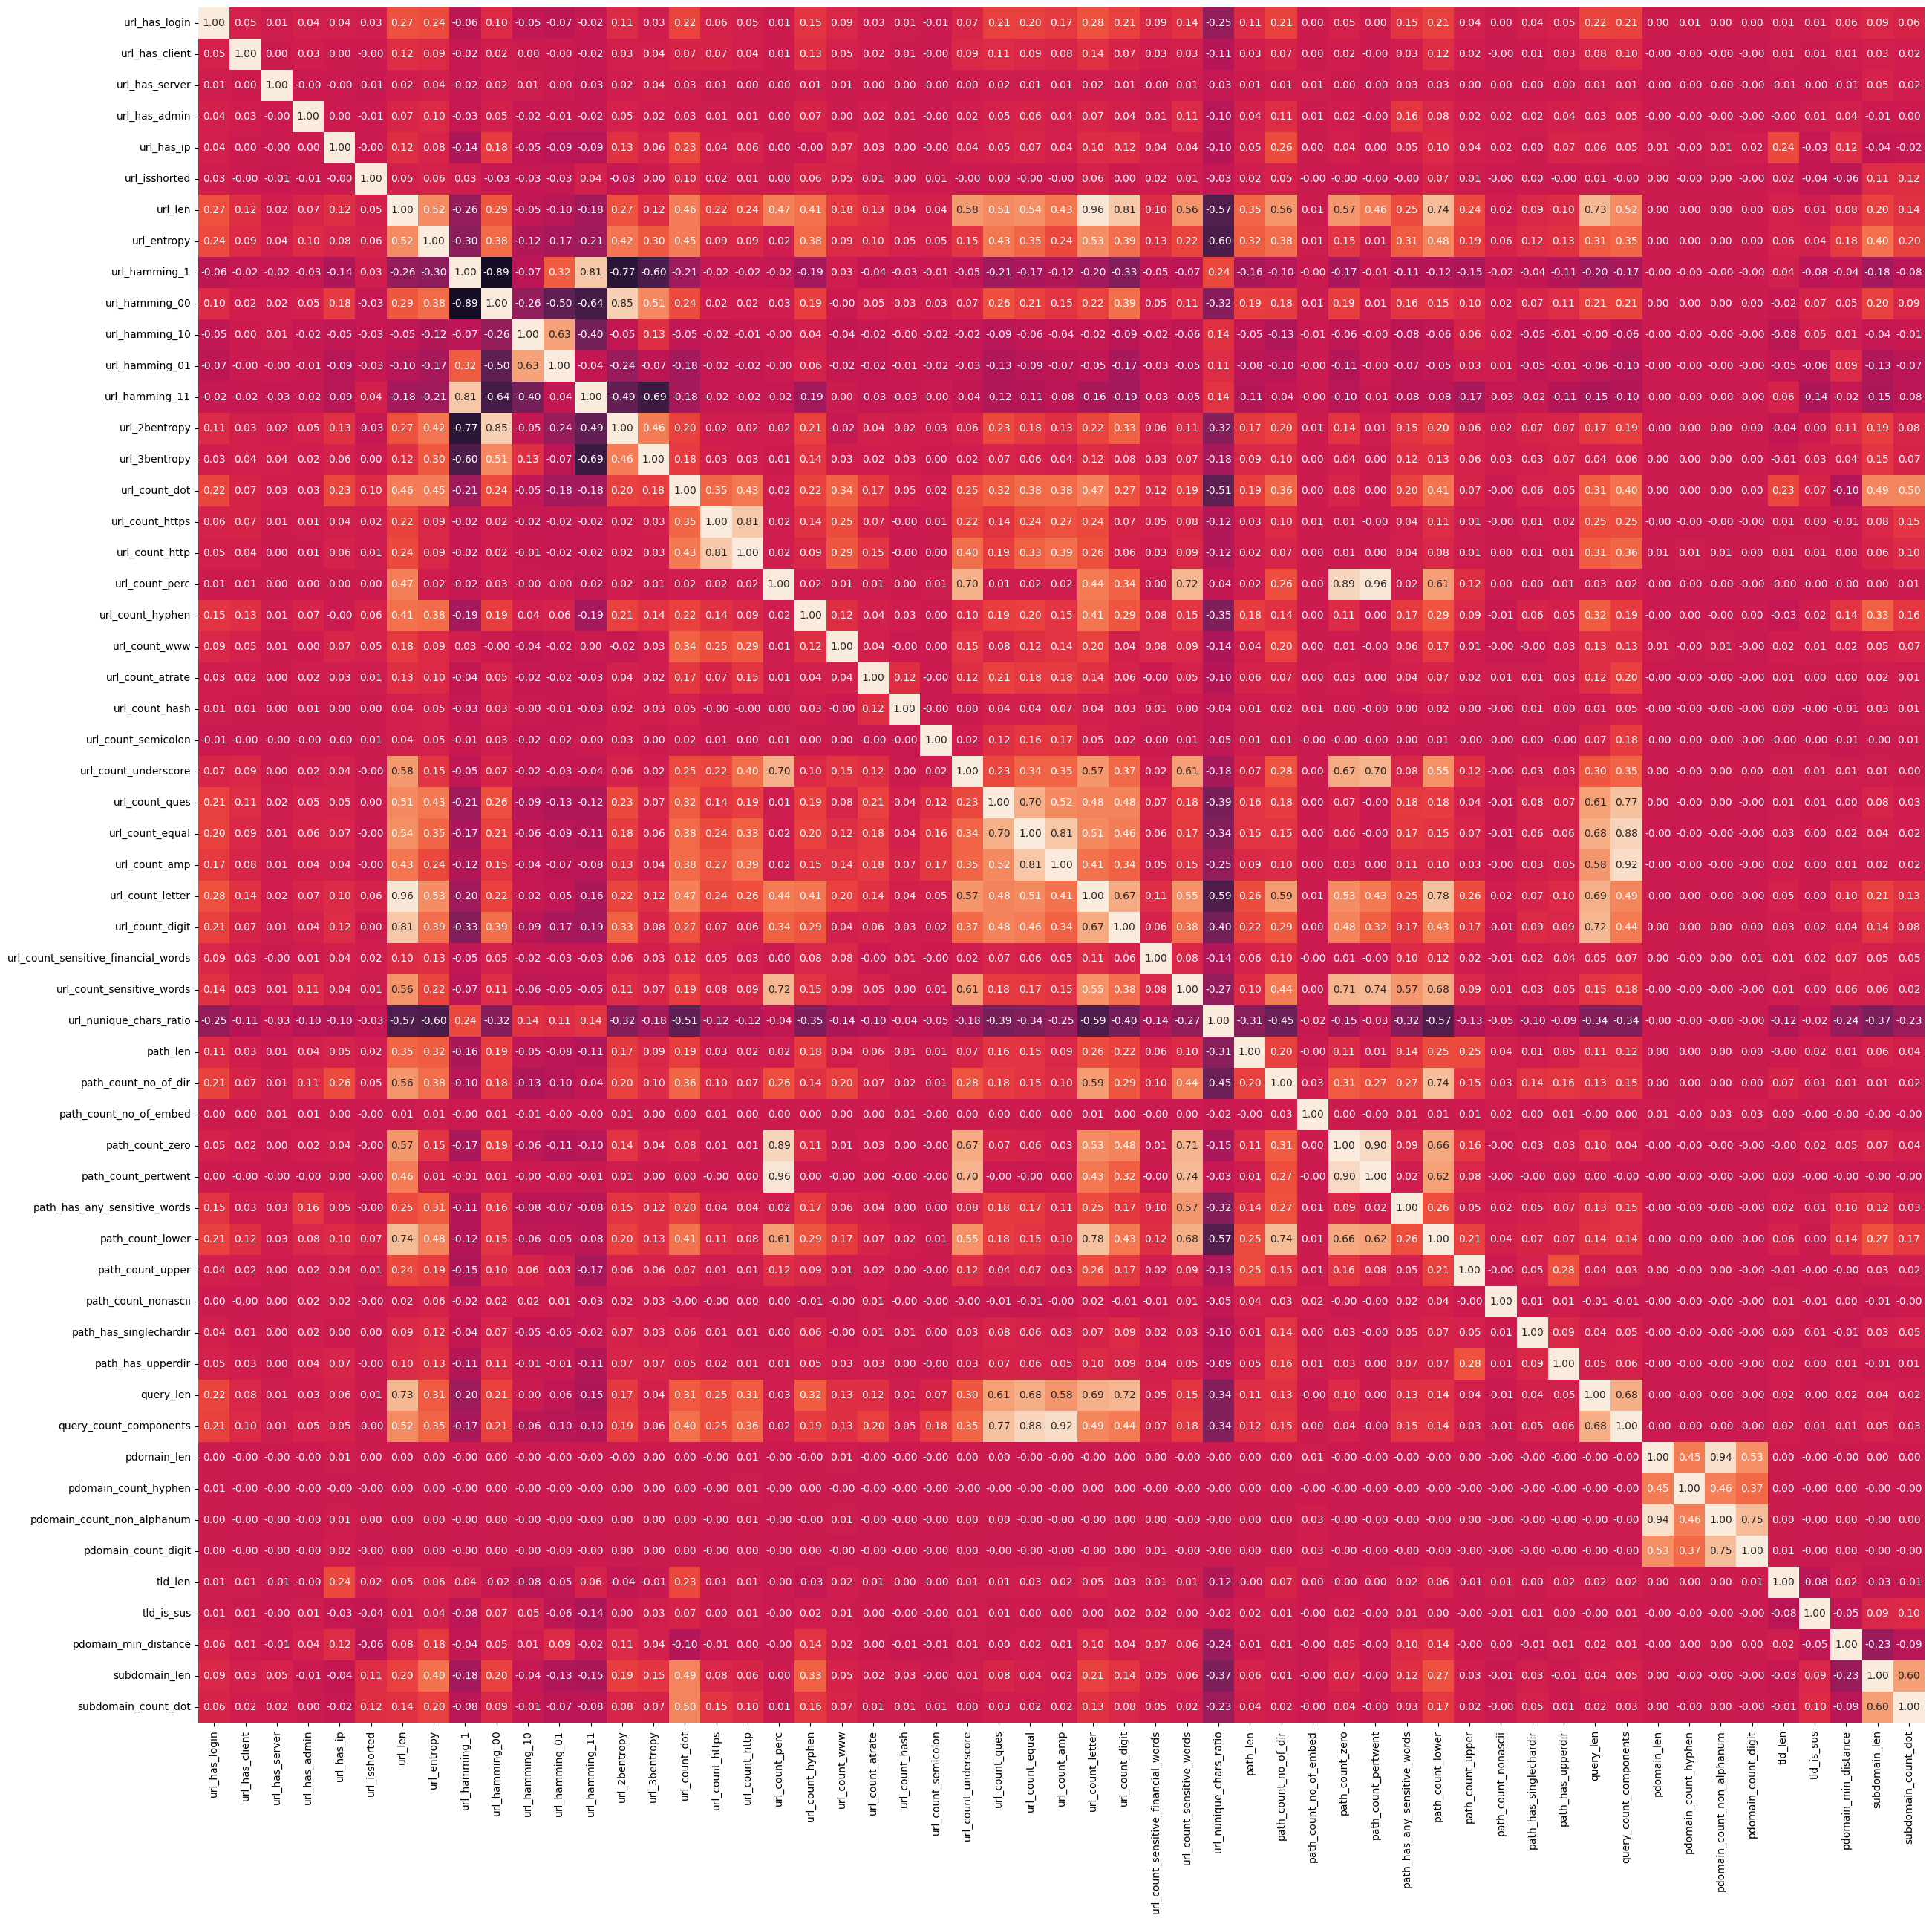

In [16]:
corr = df.toPandas()
plt.figure(figsize= (30,30))
sns.heatmap(corr[num_columns].drop(["label", "pdomain_count_atrate"], axis = 1).corr(), 
            annot = True, fmt = ".2f", vmin = -1, vmax = 1, cbar= False)
plt.show()

There's a high correlation among many columns. We need to select either one of the columns to reduce correlation among independent features. Considering the same, the columns that will be utilized for model building are as follows: - 

1. **url_len** : Highly correlated with url_entropy, url_count_letter, path_count_no_of_dir, url_count_dot, url_nunique_chars_ratio and path_count_lower. Hence, considering only url_len instead of selecting all the other columns.
2. **url_hamming_1** : Highly correlated with url_hamming_00 and url_hamming_11. Hence, considering only url_hamming_1 instead of selecting all the other columns.
3. **url_hamming_01** : Highly correlated with url_hamming_10. Hence, considering only url_hamming_10 instead of selecting all the other columns.
4. **url_2bentropy** : Highly correlated with url_3bentropy. Hence, considering only url_2bentropy instead of selecting all the other columns.
5. **pdomain_min_distance** : Highly correlated with None of the columns

## Model Building and Evaluation

In [30]:
def lr_using_spark(df):
    """ This function converts the features into vectors. Logistic Regression model is
     utilized for model training. Further, the model is evaluated using multiple metrics """

    # Specify the columns of interest
    numericColsAll  = ['url_len', 'url_hamming_1', 'url_hamming_01', 'url_2bentropy', 'pdomain_min_distance']

    # Convert the columns into vectors
    assembler = VectorAssembler(inputCols=numericColsAll , outputCol="Numfeatures")
    df = assembler.transform(df)

    # Split the data into training and testing sets
    train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

    # Create the RandomForestClassifier
    lr = LR(featuresCol="Numfeatures", labelCol="label")


    # Set up evaluator
    evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")


    # Fit the model
    lr_model = lr.fit(train_data)

    # Make predictions on the test set
    predictions = lr_model.transform(test_data)

    # Convert spark dataframe into pandas dataframe for evaluation
    y_true = test_data.select("label").toPandas()["label"]
    y_pred = predictions.select("prediction").toPandas()["prediction"]

    # Evaluate the model
    area_under_roc = evaluator.evaluate(predictions)
    print(f"Area under ROC: {area_under_roc}")
    print(f"Classification Report : \n", classification_report(y_pred= y_pred, 
                                                               y_true= y_true))
    sns.heatmap(confusion_matrix(y_true = y_true, y_pred = y_pred), annot = True, fmt= "5d")

Area under ROC: 0.8508774879155571
Classification Report : 
               precision    recall  f1-score   support

           0       0.75      0.87      0.81     50185
           1       0.85      0.71      0.77     50019

    accuracy                           0.79    100204
   macro avg       0.80      0.79      0.79    100204
weighted avg       0.80      0.79      0.79    100204



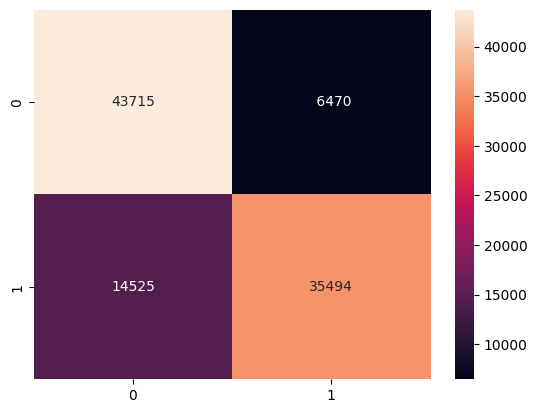

In [34]:
lr_using_spark(df) # Training and evaluating the Logistic Regression Model

According to model evaluation above, the Logistic Regression model gives an accuracy of 79% (Balanced Data)

In [22]:
def rf_using_spark(df):
    """ This function converts the features into vectors and then creates a model using 
    a spark pipeline. For finetuning, ParamGridBuilder is being leveraged. Further, the model
    is evaluated using multiple metrics """

    # Specify the columns of interest
    numericColsAll  = ['url_len', 'url_hamming_1', 'url_hamming_01', 'url_2bentropy', 'pdomain_min_distance']

    # Convert the columns into vectors
    assembler = VectorAssembler(inputCols=numericColsAll , outputCol="Numfeatures")
    df = assembler.transform(df)

    # Split the data into training and testing sets
    train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

    # Create the RandomForestClassifier
    rf = SparkRFClassifier(featuresCol="Numfeatures", labelCol="label")

    # Create a pipeline
    pipeline = Pipeline(stages=[rf])

    # Set up a parameter grid and cross-validator
    paramGrid = (ParamGridBuilder()
                 .addGrid(rf.numTrees, [10, 20, 30])
                 .addGrid(rf.maxDepth, [5, 10, 15])
                 .build())

    evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=5)

    # Fit the model
    cv_model = crossval.fit(train_data)

    # Make predictions on the test set
    predictions = cv_model.transform(test_data)

    # Convert spark dataframe into pandas dataframe for evaluation
    y_true = test_data.select("label").toPandas()["label"]
    y_pred = predictions.select("prediction").toPandas()["prediction"]

    # Evaluate the model
    area_under_roc = evaluator.evaluate(predictions)
    print(f"Area under ROC: {area_under_roc}")
    print(f"Classification Report : \n", classification_report(y_pred= y_pred, 
                                                               y_true= y_true))
    sns.heatmap(confusion_matrix(y_true = y_true, y_pred = y_pred), annot = True, fmt= "5d")
    

Area under ROC: 0.8859492745152971
Classification Report : 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83     50185
           1       0.84      0.79      0.82     50019

    accuracy                           0.82    100204
   macro avg       0.82      0.82      0.82    100204
weighted avg       0.82      0.82      0.82    100204



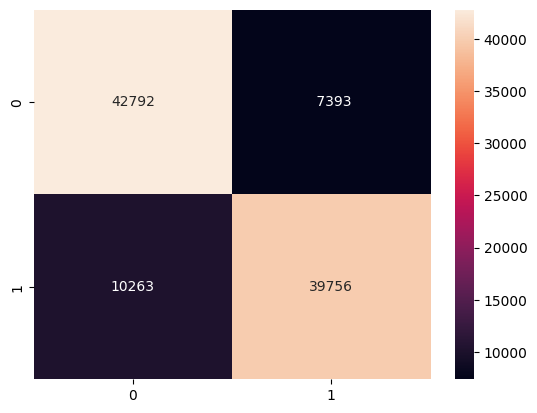

In [23]:
rf_using_spark(df) # Training and evaluating the Random Forest Model

According to model evaluation above, the Random Forest model gives an accuracy of 82% (Balanced Data)

In [35]:
def nb_using_spark(df):
    """ This function converts the features into vectors. Logistic Regression model is
     utilized for model training. Further, the model is evaluated using multiple metrics """

    # Specify the columns of interest
    numericColsAll  = ['url_len', 'url_hamming_1', 'url_hamming_01', 'url_2bentropy', 'pdomain_min_distance']

    # Convert the columns into vectors
    assembler = VectorAssembler(inputCols=numericColsAll , outputCol="Numfeatures")
    df = assembler.transform(df)

    # Split the data into training and testing sets
    train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

    # Create the RandomForestClassifier
    nb = NaiveBayes(featuresCol="Numfeatures", labelCol="label")


    # Set up evaluator
    evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")


    # Fit the model
    nb_model = nb.fit(train_data)

    # Make predictions on the test set
    predictions = nb_model.transform(test_data)

    # Convert spark dataframe into pandas dataframe for evaluation
    y_true = test_data.select("label").toPandas()["label"]
    y_pred = predictions.select("prediction").toPandas()["prediction"]

    # Evaluate the model
    area_under_roc = evaluator.evaluate(predictions)
    print(f"Area under ROC: {area_under_roc}")
    print(f"Classification Report : \n", classification_report(y_pred= y_pred, 
                                                               y_true= y_true))
    sns.heatmap(confusion_matrix(y_true = y_true, y_pred = y_pred), annot = True, fmt= "5d")

Area under ROC: 0.3833277466349176
Classification Report : 
               precision    recall  f1-score   support

           0       0.69      0.87      0.77     50185
           1       0.82      0.61      0.70     50019

    accuracy                           0.74    100204
   macro avg       0.76      0.74      0.74    100204
weighted avg       0.76      0.74      0.74    100204



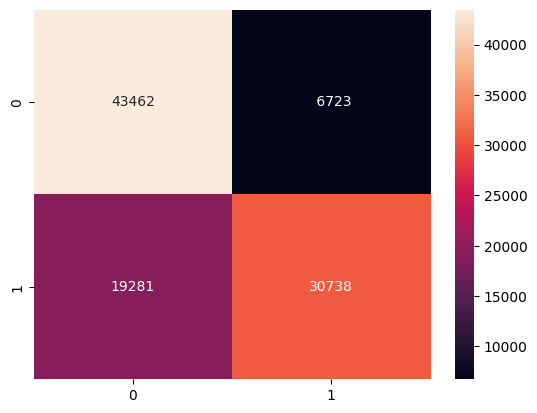

In [36]:
nb_using_spark(df) # Training and evaluating the Naive Bayes Model

According to model evaluation above, the Naive Bayes model gives an accuracy of 74% (Balanced Data)

Out of all the models developed Random Forest performs the best